La démarche suivante a été repris du site [machinelearningplus.com](https://www.machinelearningplus.com/time-series/time-series-analysis-python/)  
Bien que la logique du code ait été reprise, son adaptation a nécessité plusieurs heures de travail et d'apprentissage.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Fonction de graphique

In [2]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(32,10), dpi=dpi)
    plt.plot(x, y, color='tab:red', linestyle='-')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    #plt.savefig('foo.jpg')

# Import des fichiers

In [2]:
path = 'C:/Users/Moi/Desktop/Travail_Lille/bigdata/'
df = pd.read_csv("%sdata/modifie/trainFinal.csv" % path, parse_dates = ['date'])

In [3]:
display(df)

,Unnamed: 0,id,date,store_nbr,family,sales,onpromotion,city,state,flagHoliday,dateStoreNbr,transactions,dcoilwtico
0,0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,1,2013-01-01_1,NaN,93.12
1,1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,1,2013-01-01_1,NaN,93.12
2,2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,1,2013-01-01_1,NaN,93.12
3,3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,1,2013-01-01_1,NaN,93.12
4,4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,1,2013-01-01_1,NaN,93.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,0,2017-08-15_9,2155.0,47.57
3000884,3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,0,2017-08-15_9,2155.0,47.57
3000885,3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,0,2017-08-15_9,2155.0,47.57
3000886,3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,0,2017-08-15_9,2155.0,47.57


In [4]:
df = df.drop(['Unnamed: 0'], axis = 1)

# Ventes par jour globales

In [6]:
venteJGlobal = df[['date','sales']]

In [12]:
venteJGlobal= venteJGlobal.groupby(by=["date"], as_index = False).sum()
display(venteJGlobal)

,date,sales,Year,month,day
0,2013-01-01,2511.618999,2013,Jan,Tue
1,2013-01-02,496092.417944,2013,Jan,Wed
2,2013-01-03,361461.231124,2013,Jan,Thu
3,2013-01-04,354459.677093,2013,Jan,Fri
4,2013-01-05,477350.121229,2013,Jan,Sat
...,...,...,...,...,...
1679,2017-08-11,826373.722022,2017,Aug,Fri
1680,2017-08-12,792630.535079,2017,Aug,Sat
1681,2017-08-13,865639.677471,2017,Aug,Sun
1682,2017-08-14,760922.406081,2017,Aug,Mon


## Analyse de la saisonalité

### &emsp; Années au format datetime pandas

In [8]:
venteJGlobal['Year'] = pd.to_datetime(venteJGlobal.date).dt.year

#### Représentation graphique

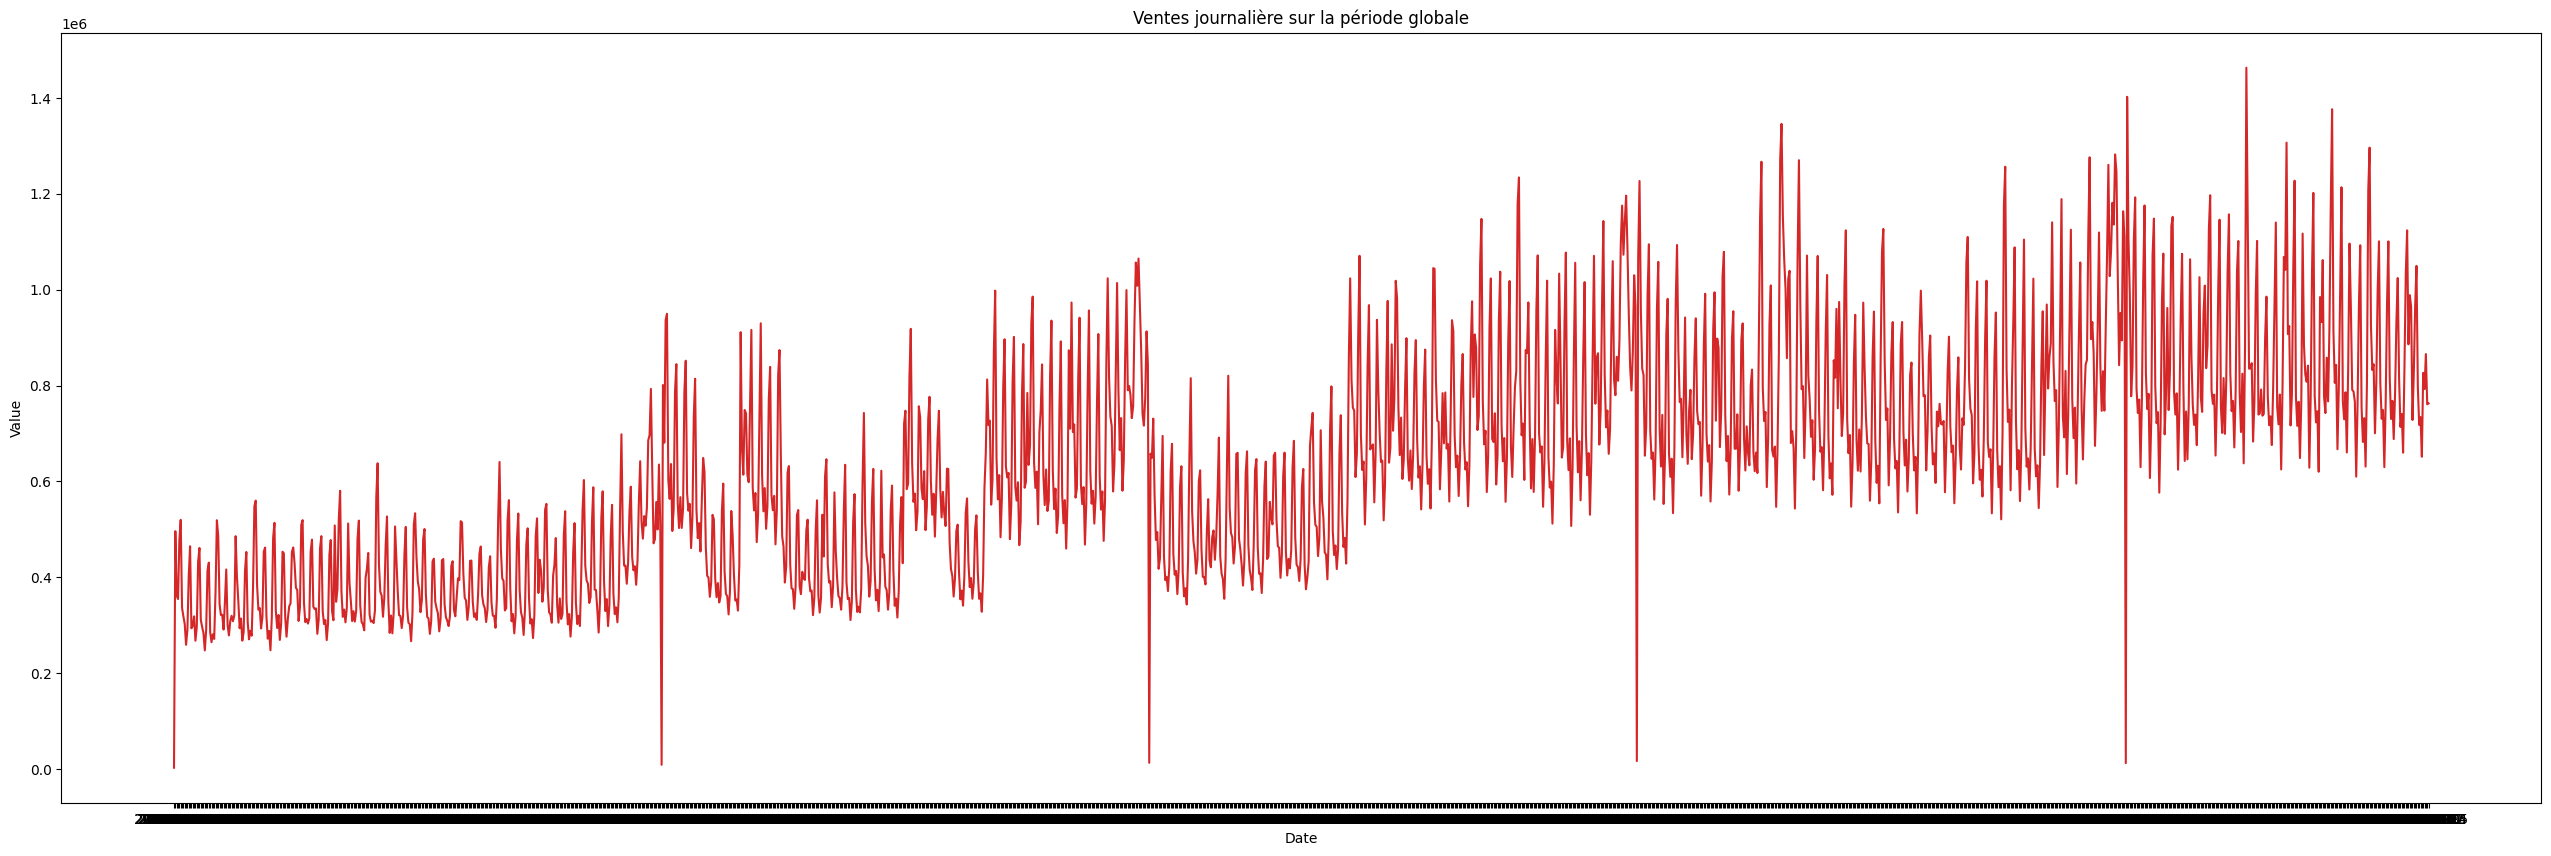

In [10]:
plot_df(venteJGlobal, x=venteJGlobal.date, y=venteJGlobal.sales, title='Ventes journalière sur la période globale')

#### On constate de gros points décendants et un motif de hauts et bas qui semble se répeter

### &emsp; Moyenne glissante 365j

In [13]:
venteJGlobalRoll = venteJGlobal.copy()
venteJGlobalRoll['salesRoll365'] = venteJGlobal['sales'].rolling(365).mean()


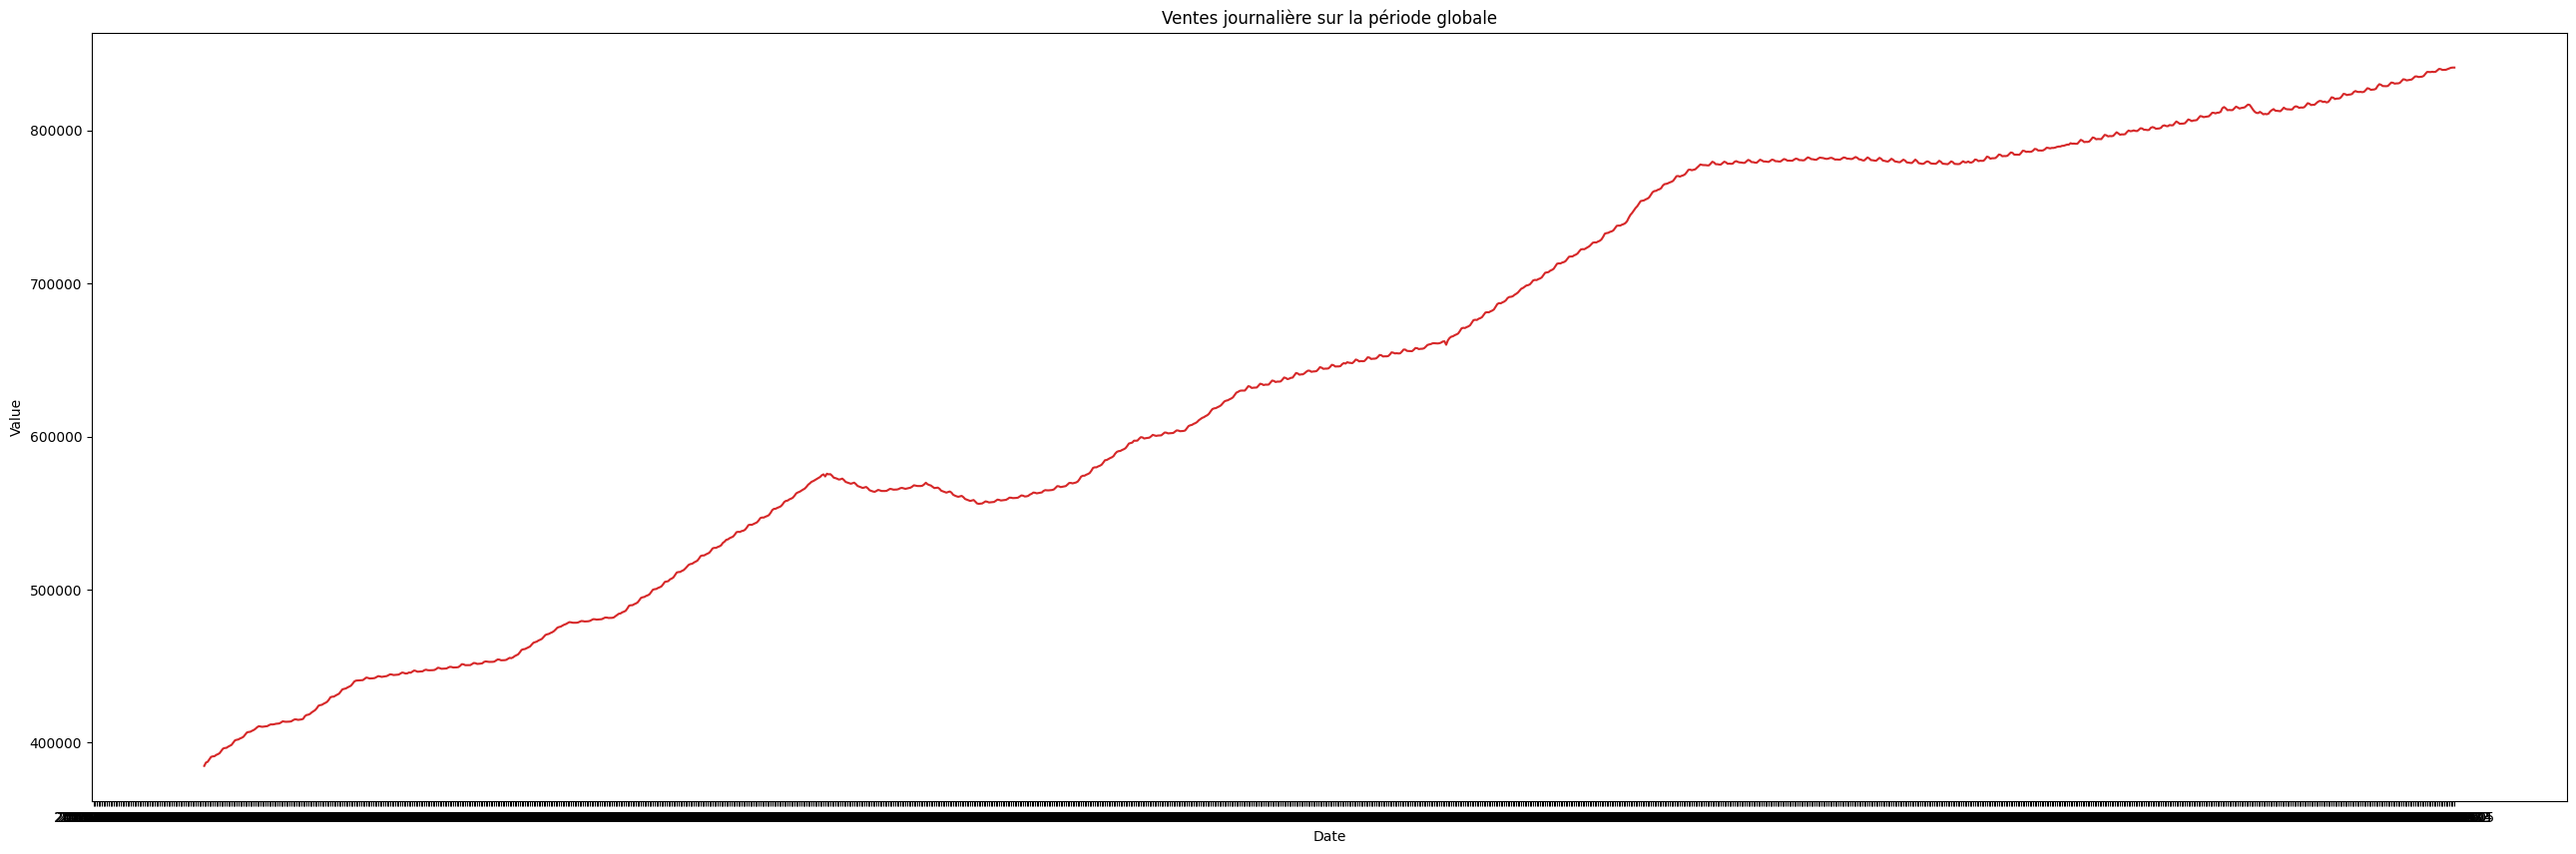

In [14]:
plot_df(venteJGlobalRoll, x=venteJGlobalRoll.date, y=venteJGlobalRoll.salesRoll365, title='Ventes journalière sur la période globale')

#### La trend est clairement croissante au fil du temps

### &emsp; Analyse sur un mois

In [15]:
venteJGlobal['month'] = pd.to_datetime(venteJGlobal.date).dt.month
vMai2013 = venteJGlobal.loc[(venteJGlobal.Year == 2013) & (venteJGlobal.month.isin([5]))].copy()

In [16]:
vMai2013['day'] = pd.to_datetime(vMai2013.date).dt.strftime("%a")
#venteJGlobal['Year'] = pd.to_datetime(venteJGlobal.date).dt.year

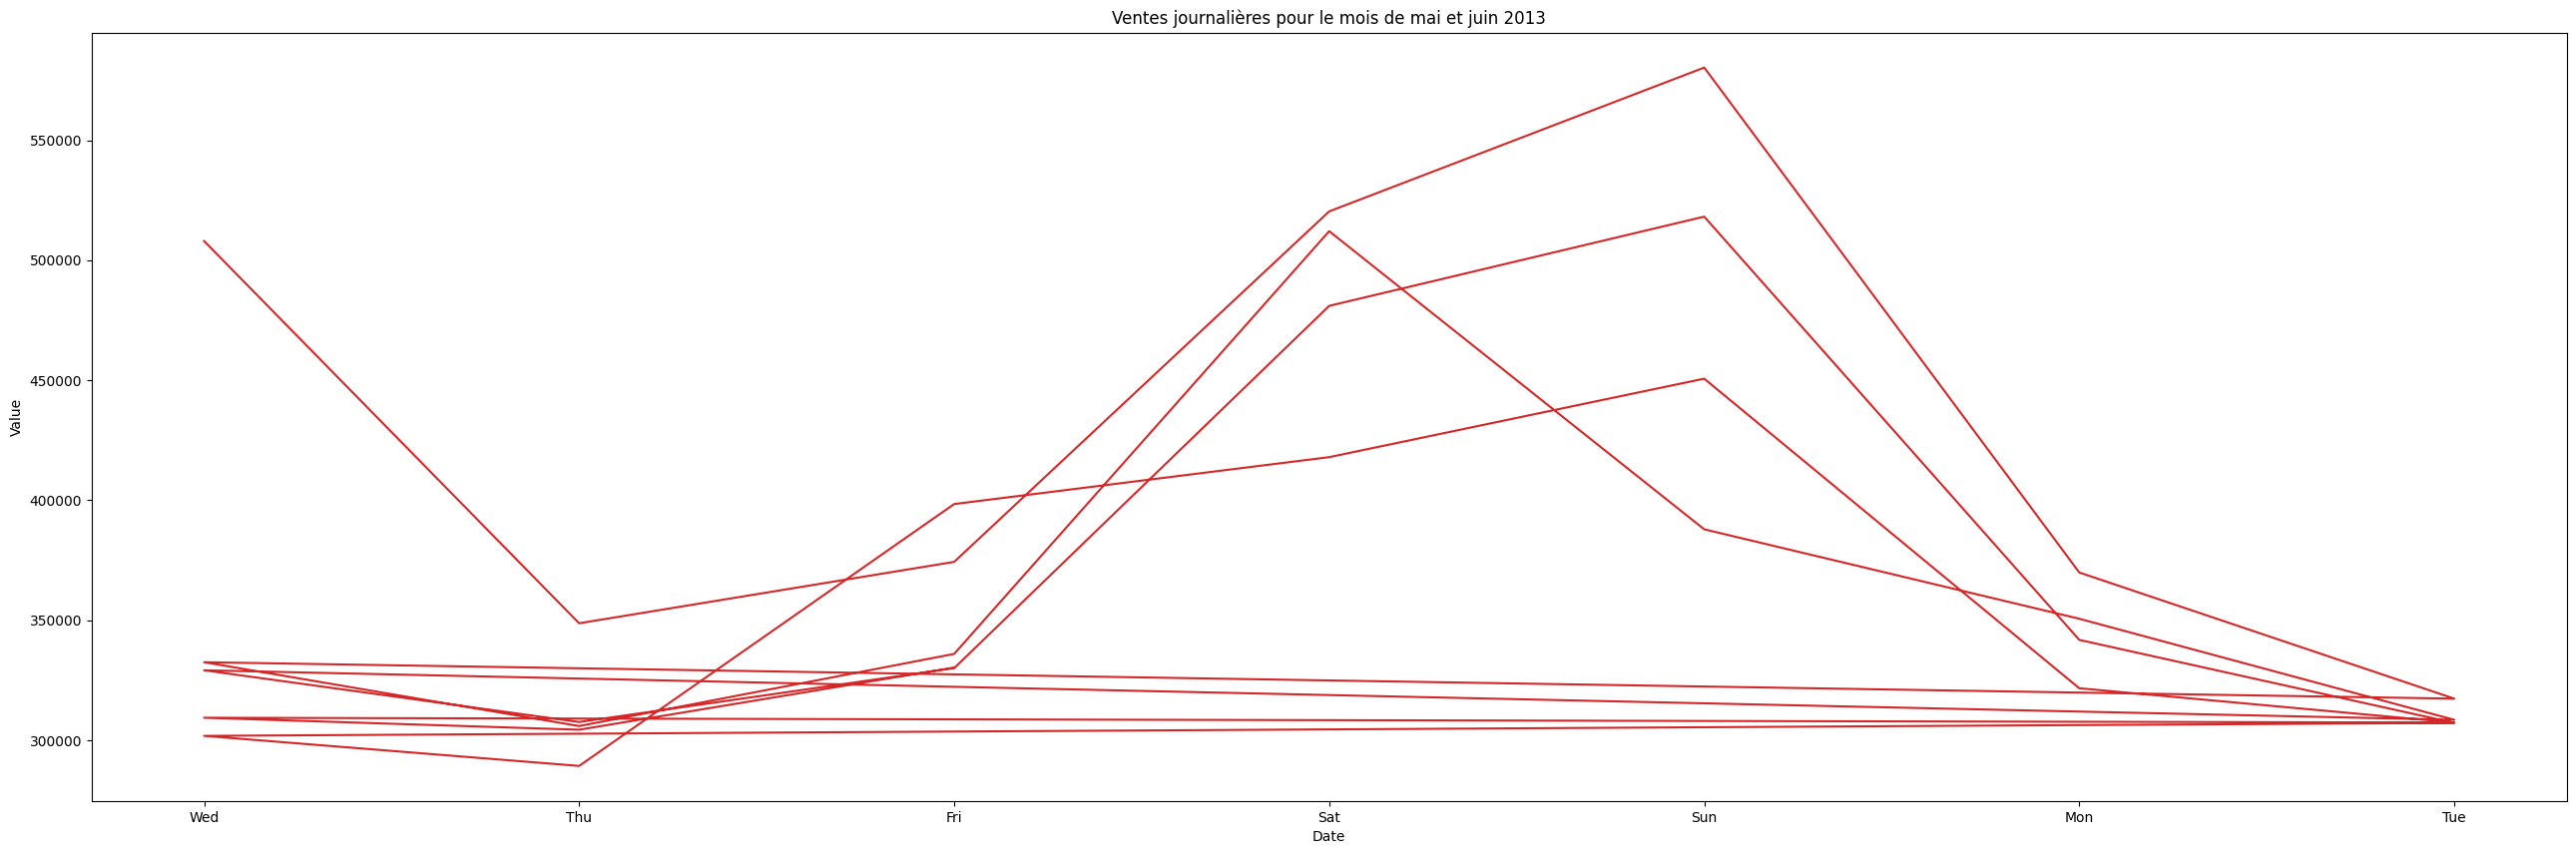

In [17]:
plot_df(vMai2013, x=vMai2013.day, y=vMai2013.sales, title='Ventes journalières pour le mois de mai et juin 2013')

Il y a une grosse variation entre les jours, avec jusuq'à 2 fois plus de vente le dimanche que les mardi, mercredi et jeudi

### &emsp; Analyse par les boîtes à moustaches

In [18]:
venteJGlobal.date = pd.to_datetime(venteJGlobal.date)

#### &emsp; &emsp; Ajout du mois et du nom du jour

In [9]:
venteJGlobal['month'] = [d.strftime('%b') for d in venteJGlobal.date]
venteJGlobal['day'] = [d.strftime("%a") for d in venteJGlobal.date]

In [10]:
print('Moyenne des ventes journalières : ' + venteJGlobal.sales.mean().round().astype(str))
print('Moyenne des ventes 2015 : ' + venteJGlobal.loc[(venteJGlobal.Year == 2015)].sales.mean().round().astype(str))
print('Moyenne des ventes septembre : ' + venteJGlobal.loc[(venteJGlobal.month == 'Sep')].sales.mean().round().astype(str))
print('Moyenne des ventes vendredi : ' + venteJGlobal.loc[(venteJGlobal.day == 'Fri')].sales.mean().round().astype(str))

Moyenne des ventes journalières : 637556.0
Moyenne des ventes 2015 : 661759.0
Moyenne des ventes septembre : 645614.0
Moyenne des ventes vendredi : 579574.0


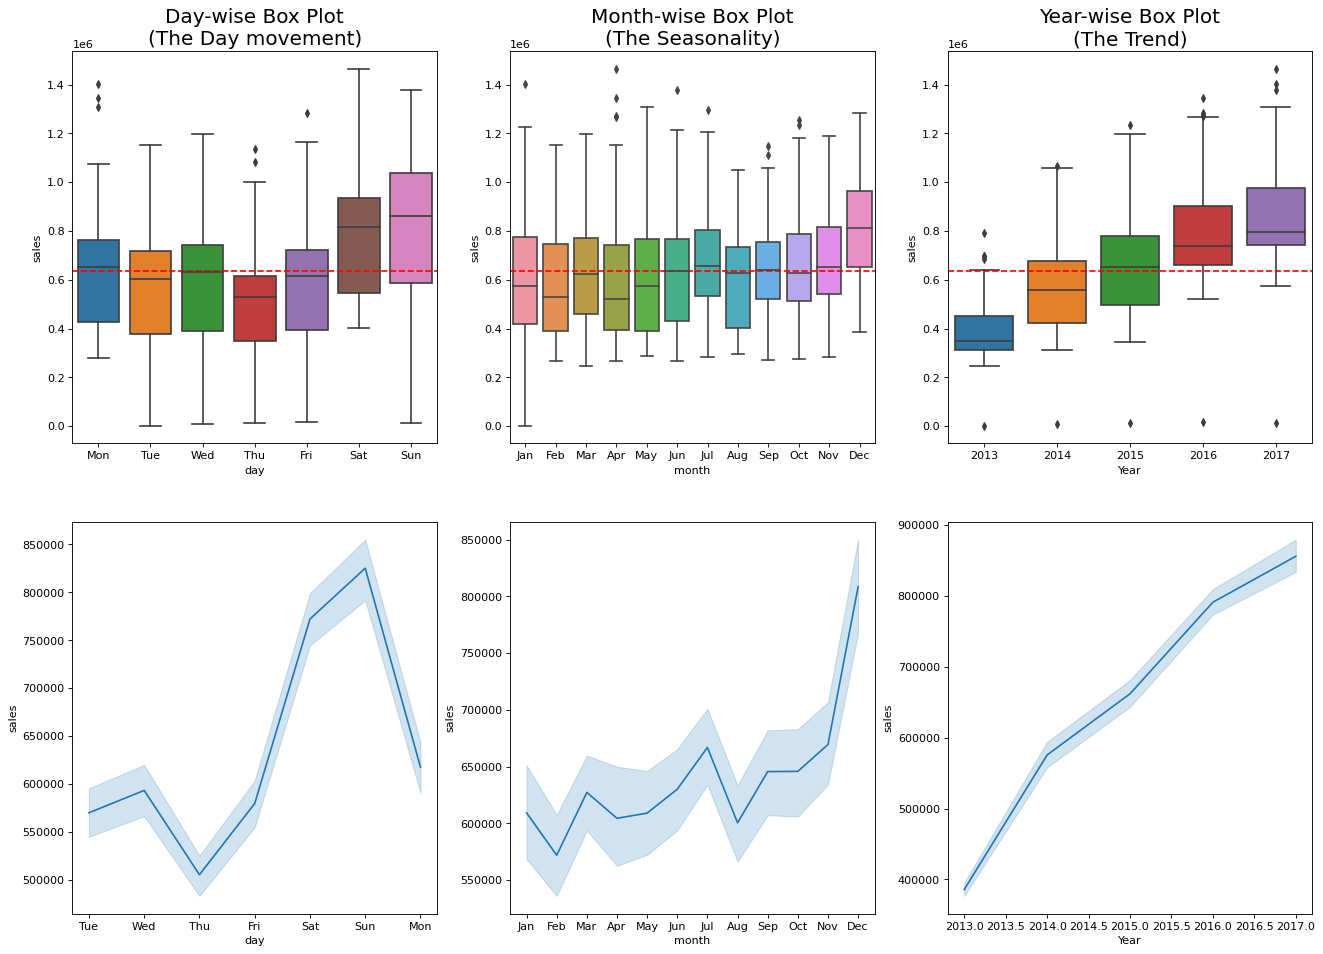

In [11]:
# Draw Plot
fig, axes = plt.subplots(2, 3, figsize=(20,14), dpi= 80)
sns.boxplot(x='Year', y='sales', data=venteJGlobal, ax=axes[0,2])
sns.boxplot(x='month', y='sales', data=venteJGlobal, ax=axes[0,1])
sns.boxplot(x='day', order =['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], y='sales', data=venteJGlobal, ax=axes[0,0])

sns.lineplot(x='Year', y='sales', data=venteJGlobal, ax=axes[1,2])
sns.lineplot(x='month', y='sales', data=venteJGlobal, ax=axes[1,1])
sns.lineplot(x='day', sort = True, y='sales', data=venteJGlobal, ax=axes[1,0])


axes[0,2].axhline(y=637556, color='r', linestyle='--', label='Horizontal Line at 0.6')
axes[0,1].axhline(y=637556, color='r', linestyle='--', label='Horizontal Line at 0.8')
axes[0,0].axhline(y=637556, color='r', linestyle='--', label='Horizontal Line at 0.8')


# Set Title
axes[0,2].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18)
axes[0,1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
axes[0,0].set_title('Day-wise Box Plot\n(The Day movement)', fontsize=18); 
plt.show()

Ligne de référence par rapport à la moyenne journalière globale

# Analyse par Jour Magasin

In [40]:
venteJStore = df[['date','store_nbr','sales']]

In [41]:
venteJStore= venteJStore.groupby(by=['date','store_nbr'], as_index = False).sum()
display(venteJStore)

,date,store_nbr,sales
0,2013-01-01,1,0.000000
1,2013-01-01,2,0.000000
2,2013-01-01,3,0.000000
3,2013-01-01,4,0.000000
4,2013-01-01,5,0.000000
...,...,...,...
90931,2017-08-15,50,16879.121004
90932,2017-08-15,51,20154.559000
90933,2017-08-15,52,18600.046000
90934,2017-08-15,53,8208.189000


## &emsp; Ventes par magasin sur toute la période

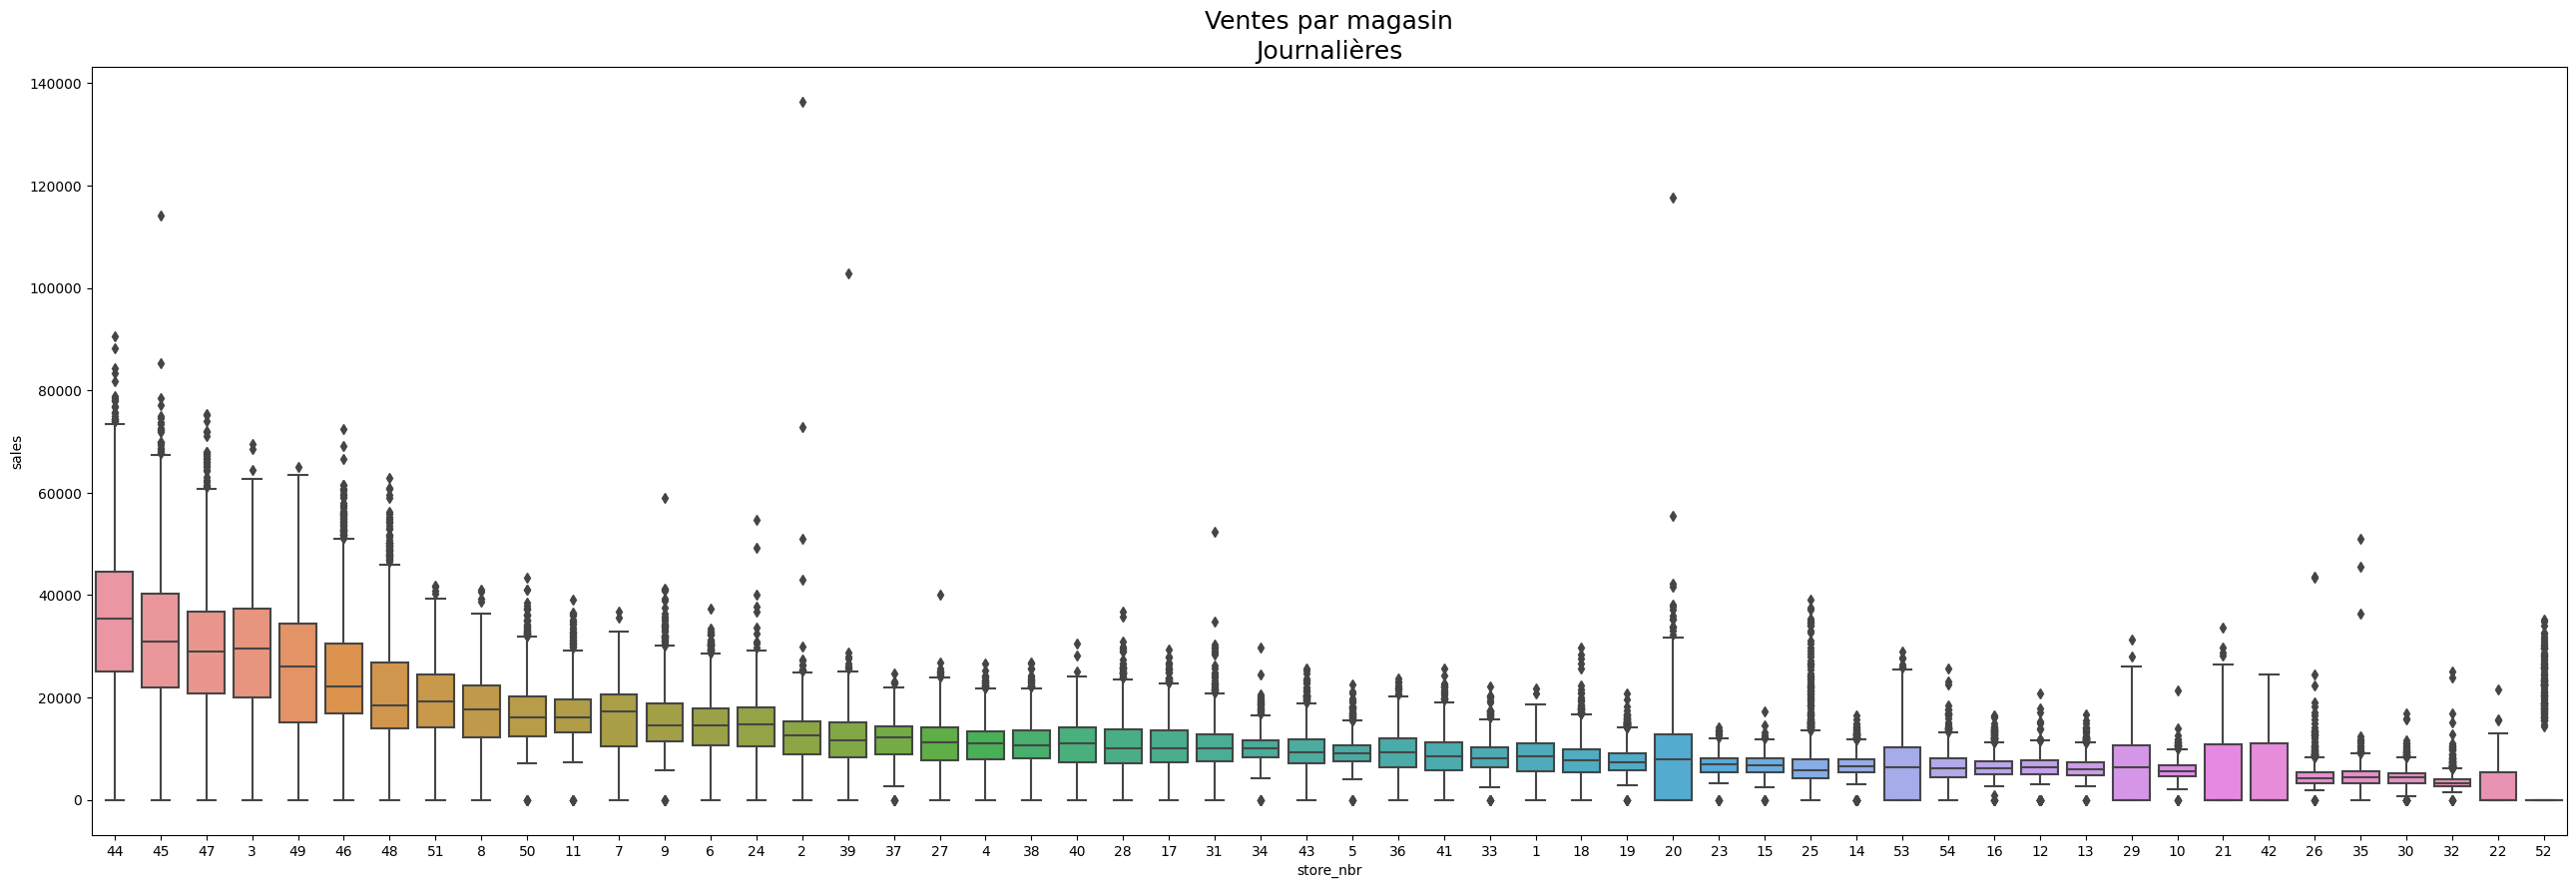

In [54]:
group_means=venteJStore.groupby(['store_nbr'])['sales'].mean().sort_values(ascending=False).index

# Draw Plot
plt.figure(figsize=(32,10), dpi=100)

sns.boxplot(x='store_nbr', y='sales', data=venteJStore, order=group_means).set_title('Ventes par magasin\nJournalières', fontsize=18)
plt.show()

# Analyse par Jour Cluster Magasin

In [7]:
display(df)

,date,store_nbr,family,sales,onpromotion,city_x,state_x,flagHoliday,dateStoreNbr,transactions,dcoilwtico,type,cluster
0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,1,2013-01-01_1,NaN,93.12,D,13
1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,1,2013-01-01_1,NaN,93.12,D,13
2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,1,2013-01-01_1,NaN,93.12,D,13
3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,1,2013-01-01_1,NaN,93.12,D,13
4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,1,2013-01-01_1,NaN,93.12,D,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,0,2017-08-15_9,2155.0,47.57,B,6
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,0,2017-08-15_9,2155.0,47.57,B,6
3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,0,2017-08-15_9,2155.0,47.57,B,6
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,0,2017-08-15_9,2155.0,47.57,B,6


In [16]:
venteJClusterStore = df[['date','cluster','sales']].copy()
venteJClusterStore['year'] = pd.to_datetime(venteJClusterStore.date).dt.year

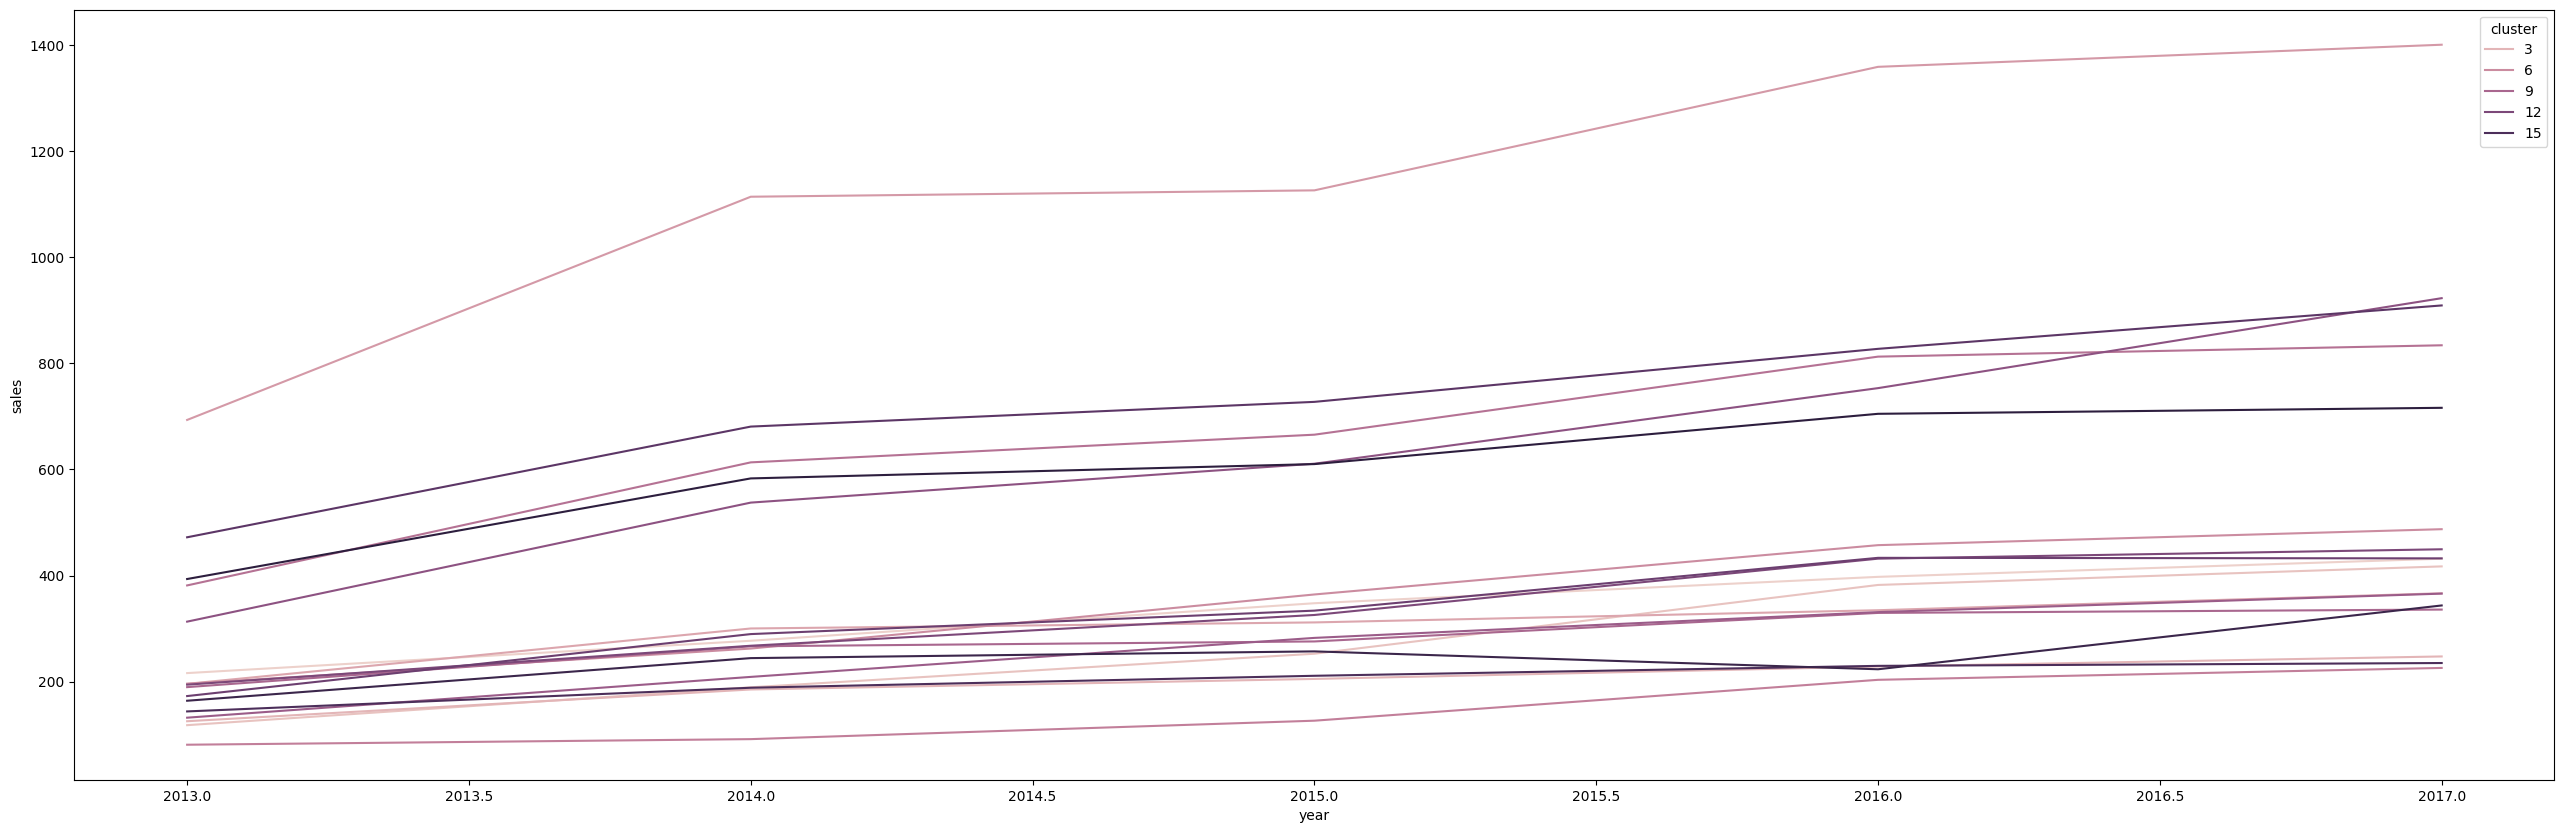

In [18]:
# Draw Plot

plt.figure(figsize=(32,10), dpi=100)
sns.lineplot(x='year', y='sales', hue = 'cluster', errorbar=None, data=venteJClusterStore)
 
plt.show()

# Trend, saisonalité, residu

## Création d'un DateTimeIndex

In [194]:
#venteJGlobal['date'] = venteJGlobal.index

In [186]:
venteJGlobal['Datetime'] = pd.to_datetime(venteJGlobal['date'], format = '%m-%d-%Y')
venteJGlobal = venteJGlobal.set_index(['Datetime']).asfreq('d')

### Gestion des valeurs manquantes

In [185]:
print(venteJGlobal.sales.isnull().sum().astype(str) + ' valeurs manquantes')
display(venteJGlobal.loc[(venteJGlobal.sales.isnull() == True)])
venteJGlobal = venteJGlobal.fillna(method='ffill')

0 valeurs manquantes


,sales,date
Datetime,,


In [195]:
#venteJGlobal = venteJGlobal.drop(['date'], axis=1)
display(venteJGlobal)

,sales,date
Datetime,,
2013-01-01,2511.618999,2013-01-01
2013-01-02,496092.417944,2013-01-02
2013-01-03,361461.231124,2013-01-03
2013-01-04,354459.677093,2013-01-04
2013-01-05,477350.121229,2013-01-05
...,...,...
2017-08-11,826373.722022,2017-08-11
2017-08-12,792630.535079,2017-08-12
2017-08-13,865639.677471,2017-08-13


In [ ]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(venteJGlobal.sales, model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(venteJGlobal.sales, model='additive', extrapolate_trend='freq')


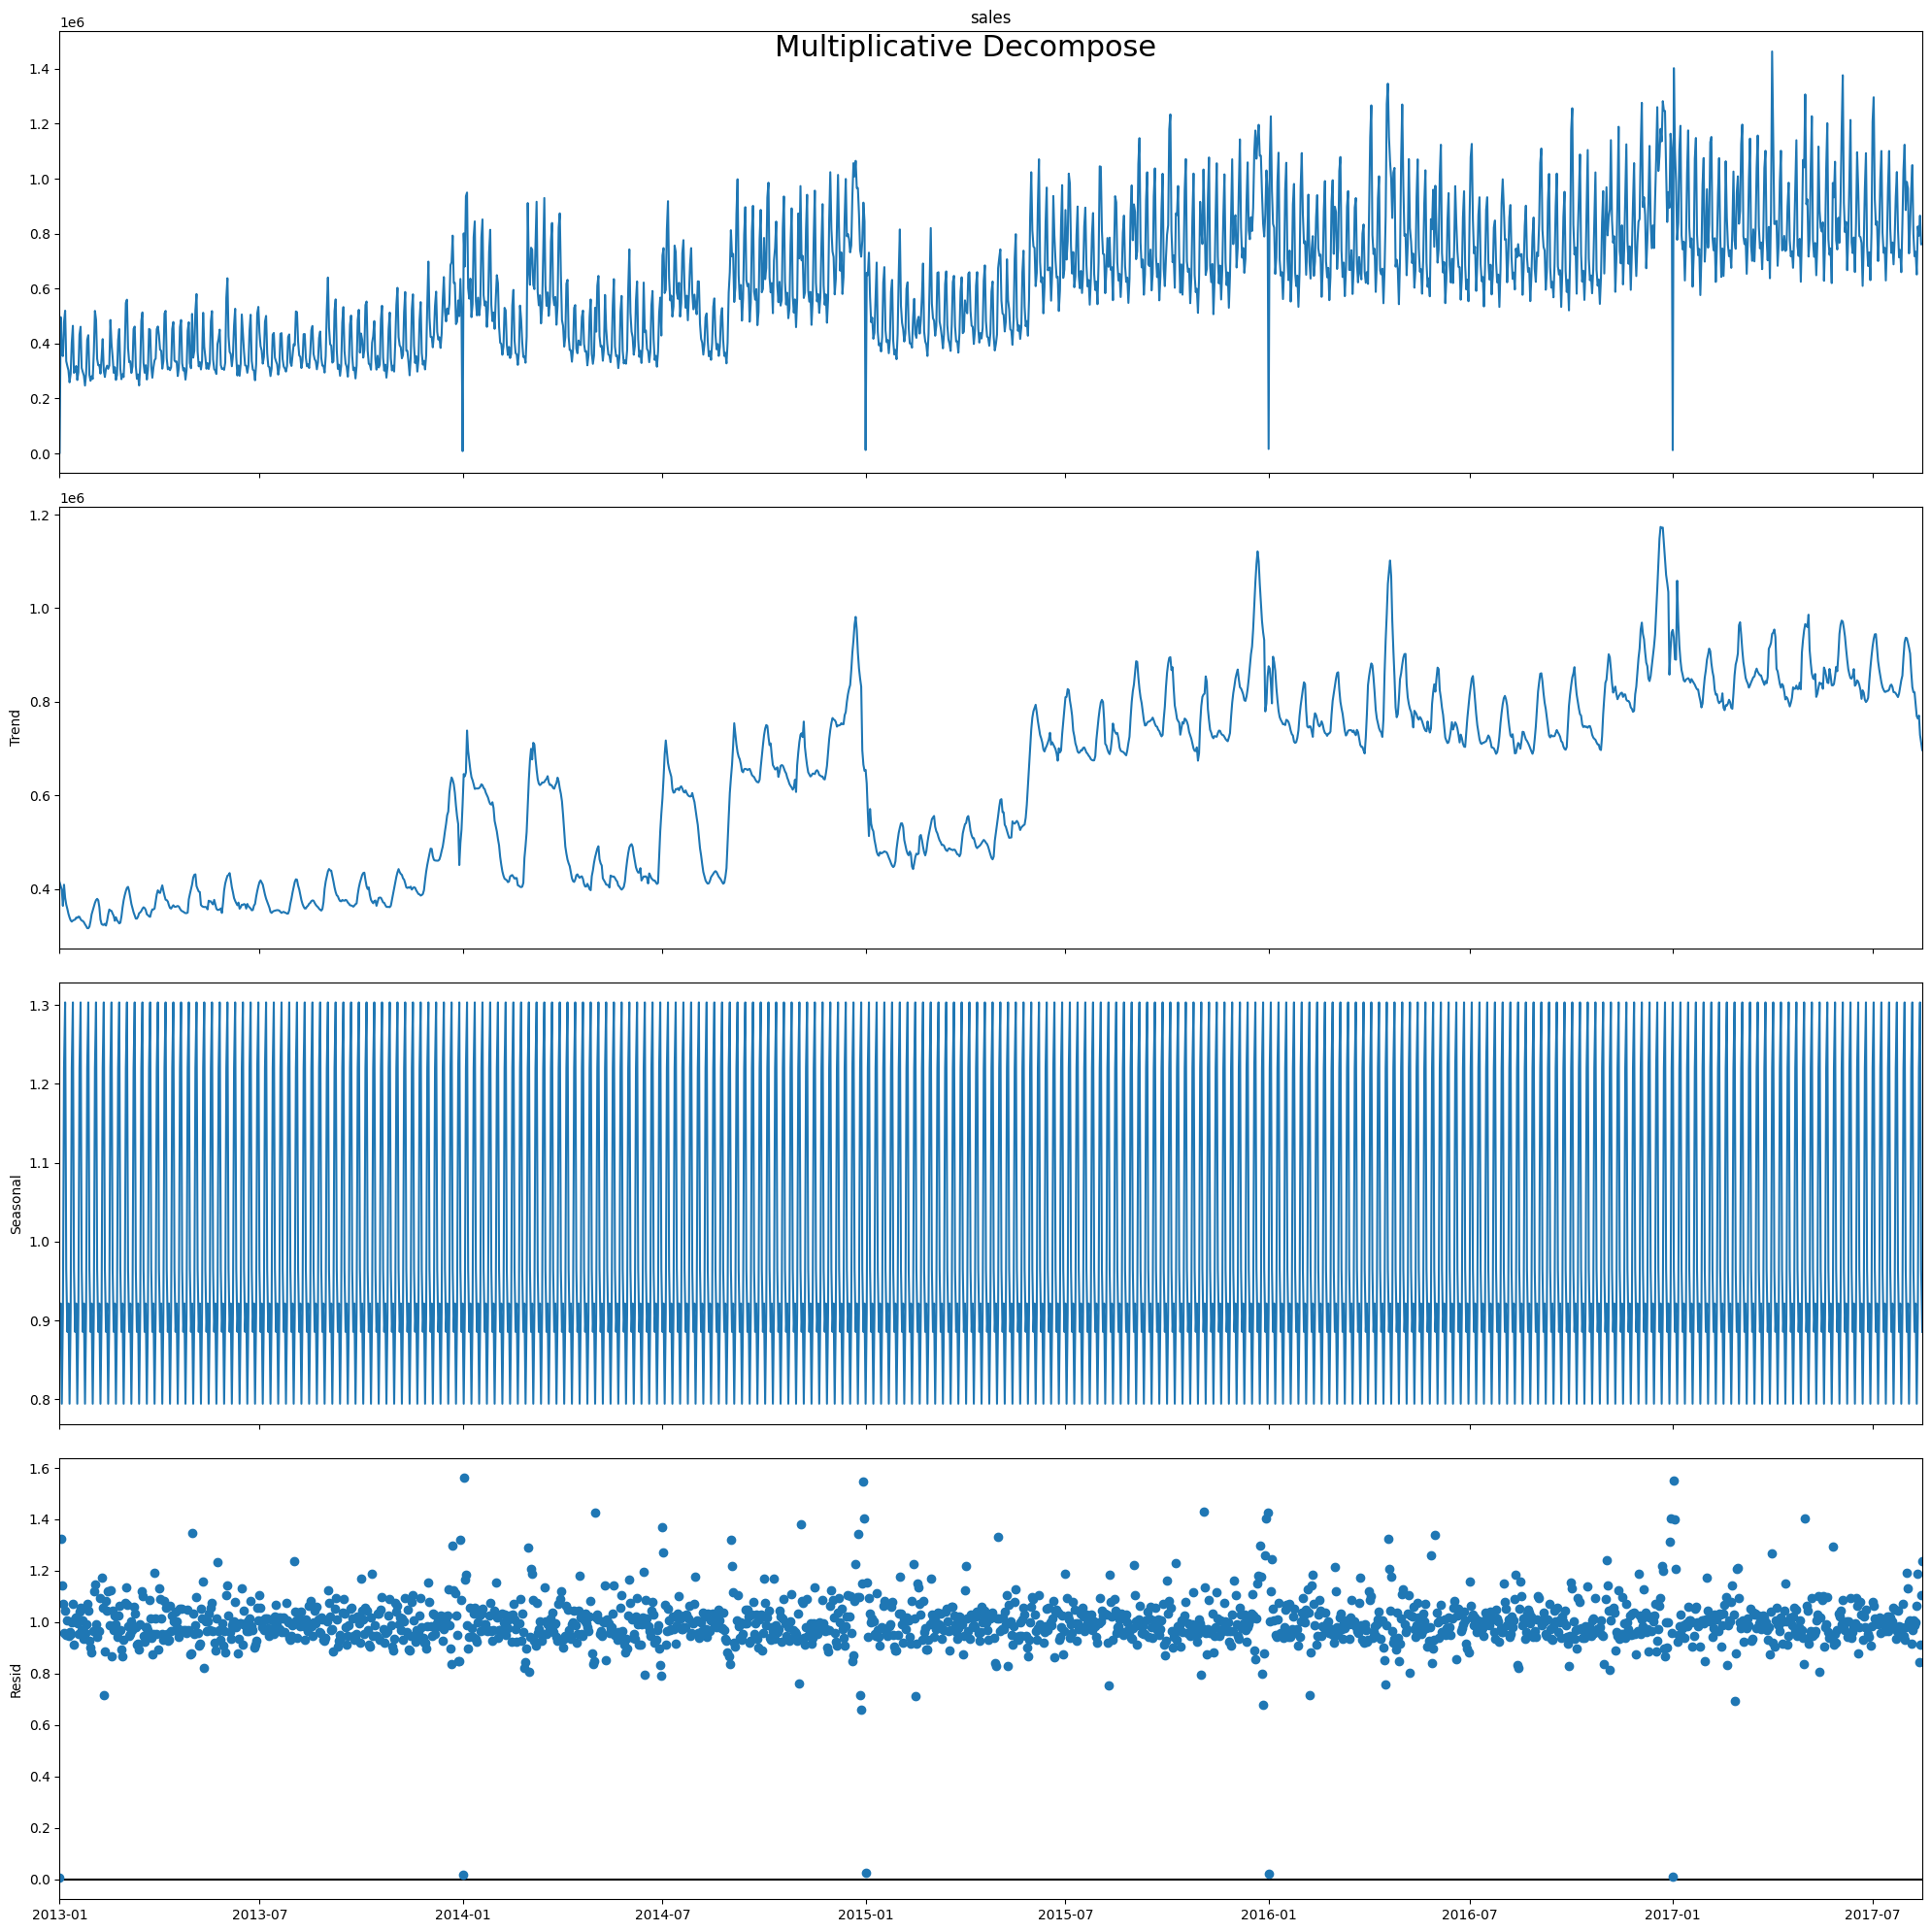

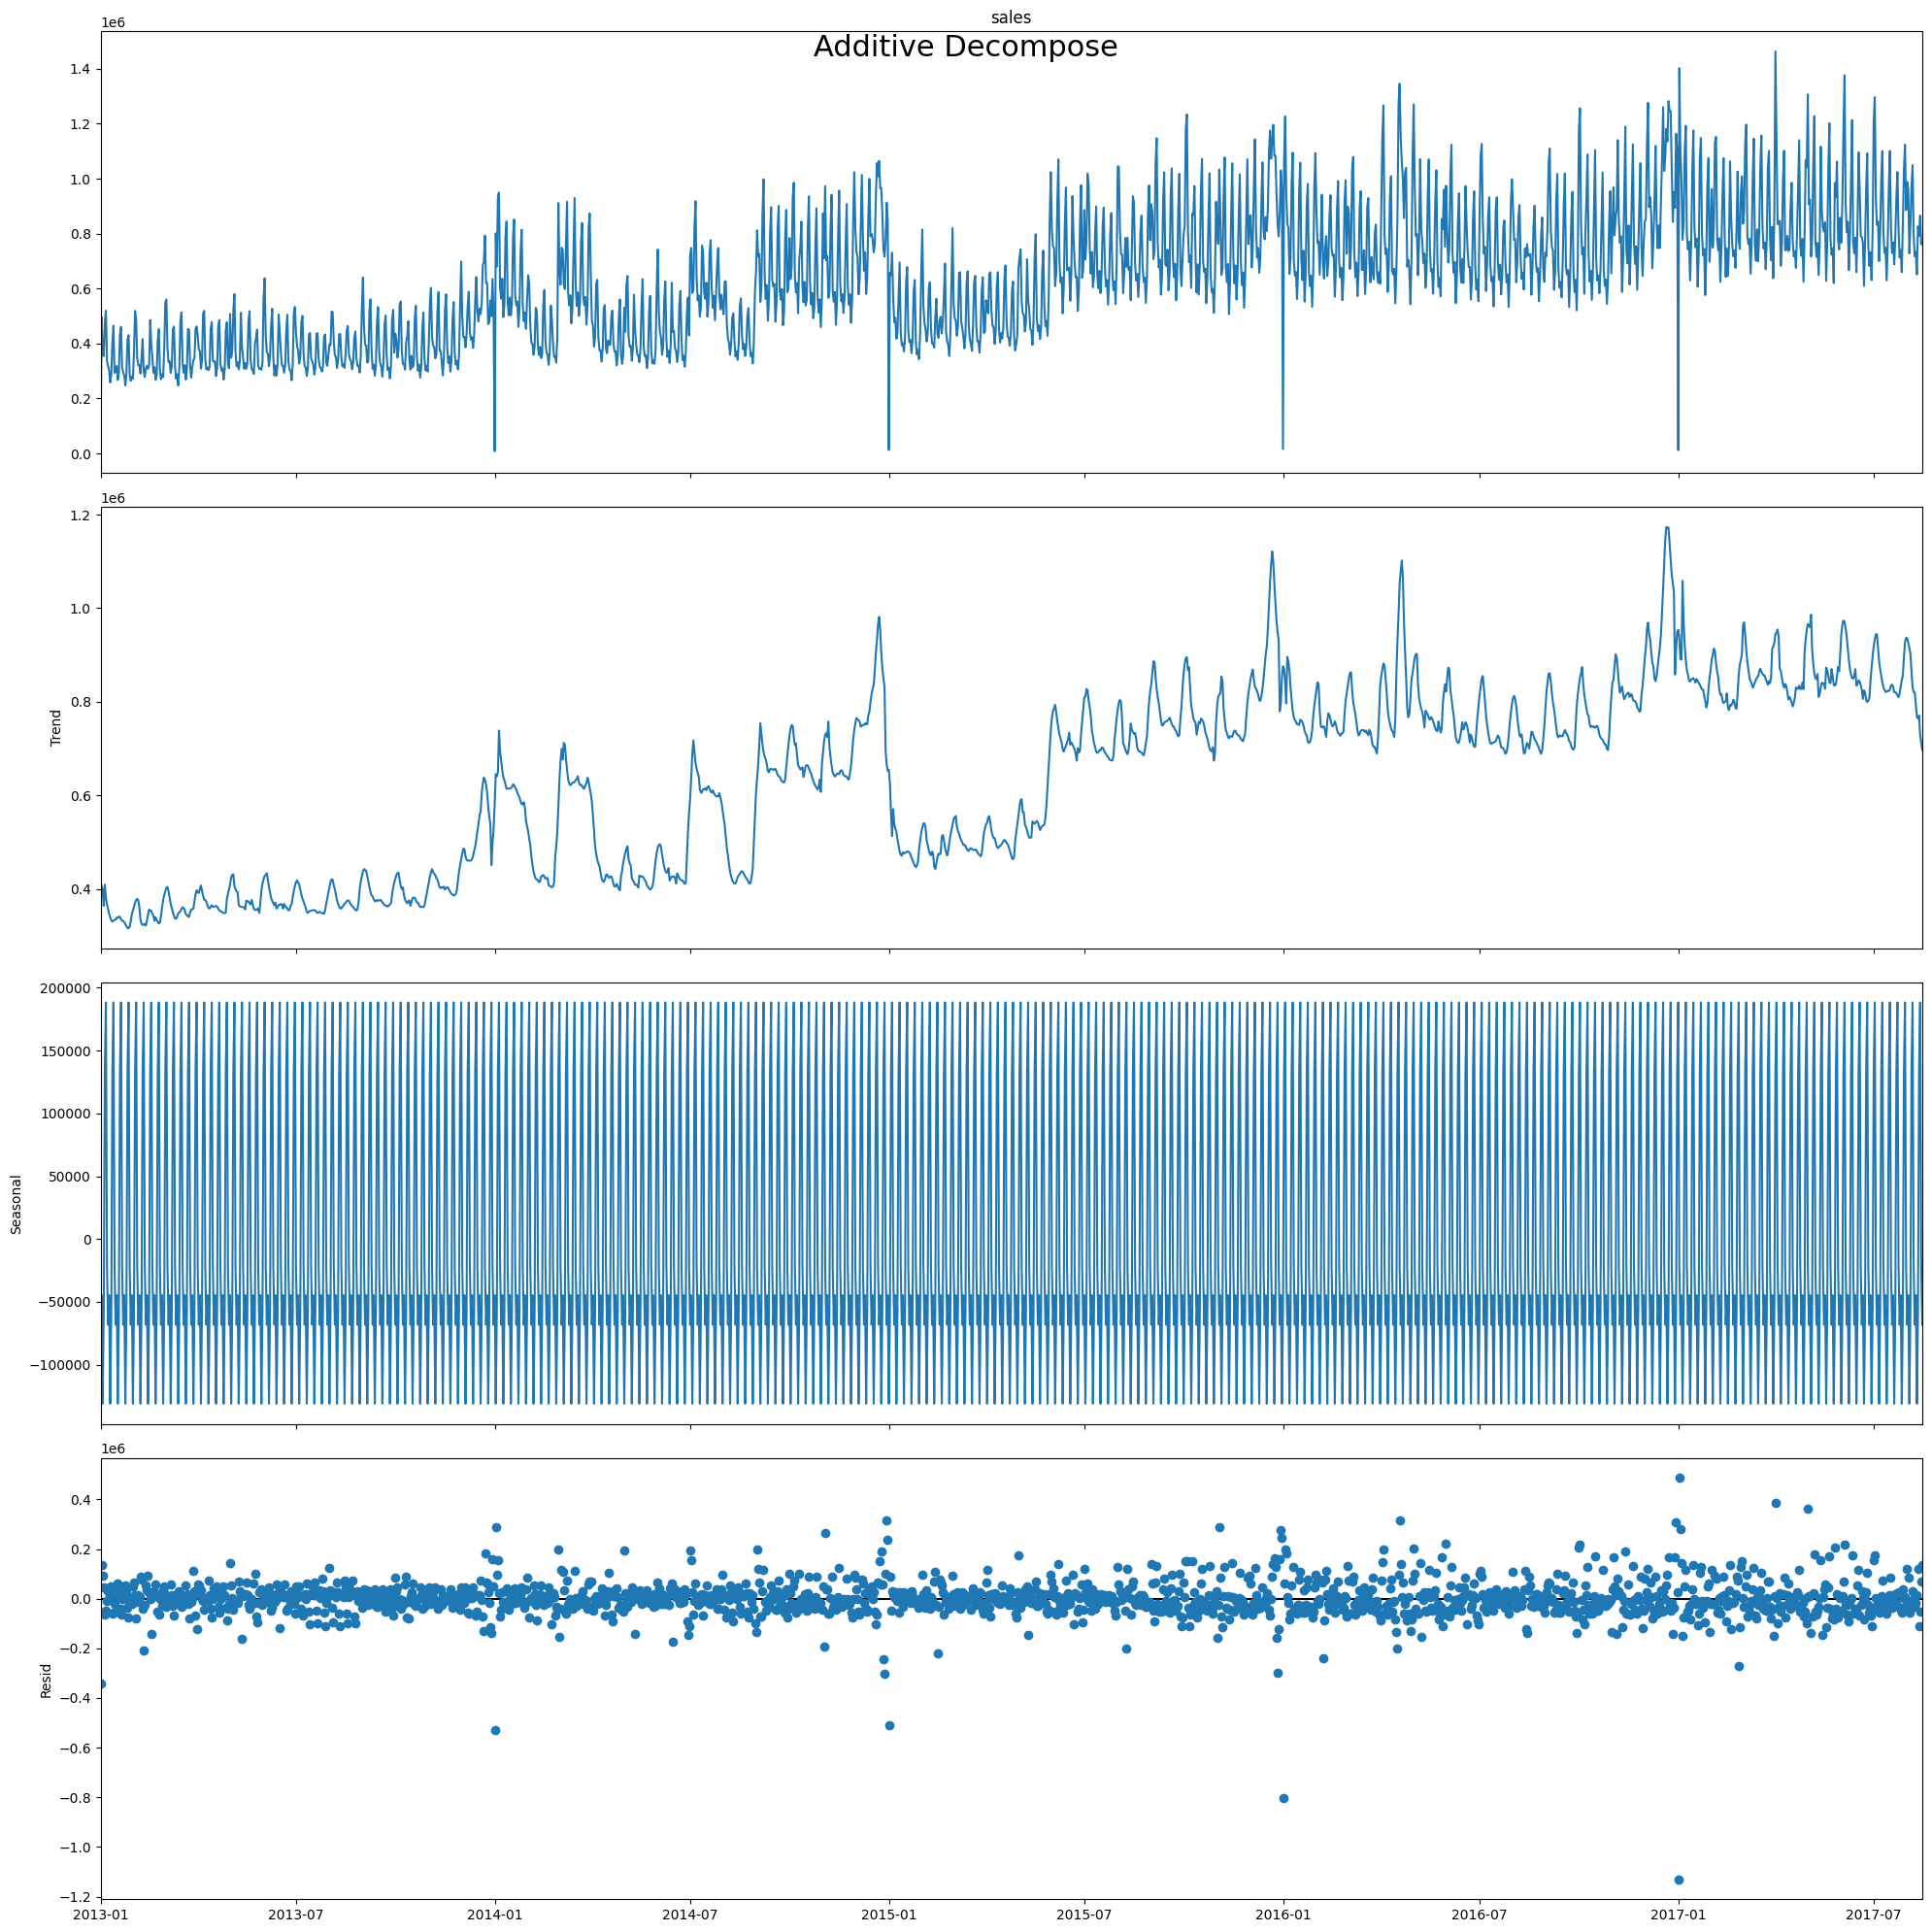

In [196]:
# Plot
plt.rcParams.update({'figure.figsize': (20,20)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [197]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
Datetime,,,,
2013-01-01,0.885663,414131.504480,0.006848,2511.618999
2013-01-02,0.921595,406176.723901,1.325279,496092.417944
2013-01-03,0.794614,398221.943322,1.142301,361461.231124
2013-01-04,0.910231,363956.181220,1.069957,354459.677093
2013-01-05,1.219888,409075.632504,0.956563,477350.121229


# Ajout d'information

In [42]:
test = pd.read_csv("%sdata/modifie/testFinal.csv" % path, parse_dates = ['date'], index_col='date')
display(test)

,Unnamed: 0,store_nbr,family,onpromotion,city,state,flagHoliday,transactions,dcoilwtico,type,cluster
date,,,,,,,,,,,
2017-08-16,0,1,AUTOMOTIVE,0,Quito,Pichincha,0,NaN,46.80,D,13
2017-08-16,1,1,BABY CARE,0,Quito,Pichincha,0,NaN,46.80,D,13
2017-08-16,2,1,BEAUTY,2,Quito,Pichincha,0,NaN,46.80,D,13
2017-08-16,3,1,BEVERAGES,20,Quito,Pichincha,0,NaN,46.80,D,13
2017-08-16,4,1,BOOKS,0,Quito,Pichincha,0,NaN,46.80,D,13
...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,28507,9,POULTRY,1,Quito,Pichincha,0,NaN,47.26,B,6
2017-08-31,28508,9,PREPARED FOODS,0,Quito,Pichincha,0,NaN,47.26,B,6
2017-08-31,28509,9,PRODUCE,1,Quito,Pichincha,0,NaN,47.26,B,6


In [43]:
test['mois'] = [d.strftime('%b') for d in test.index]
test['jour'] = [d.strftime("%a") for d in test.index]
display(test)

,Unnamed: 0,store_nbr,family,onpromotion,city,state,flagHoliday,transactions,dcoilwtico,type,cluster,mois,jour
date,,,,,,,,,,,,,
2017-08-16,0,1,AUTOMOTIVE,0,Quito,Pichincha,0,NaN,46.80,D,13,Aug,Wed
2017-08-16,1,1,BABY CARE,0,Quito,Pichincha,0,NaN,46.80,D,13,Aug,Wed
2017-08-16,2,1,BEAUTY,2,Quito,Pichincha,0,NaN,46.80,D,13,Aug,Wed
2017-08-16,3,1,BEVERAGES,20,Quito,Pichincha,0,NaN,46.80,D,13,Aug,Wed
2017-08-16,4,1,BOOKS,0,Quito,Pichincha,0,NaN,46.80,D,13,Aug,Wed
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,28507,9,POULTRY,1,Quito,Pichincha,0,NaN,47.26,B,6,Aug,Thu
2017-08-31,28508,9,PREPARED FOODS,0,Quito,Pichincha,0,NaN,47.26,B,6,Aug,Thu
2017-08-31,28509,9,PRODUCE,1,Quito,Pichincha,0,NaN,47.26,B,6,Aug,Thu


In [44]:
test.to_csv('data/modifie/testFinal.csv', index=False)